In [1]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
ee.Authenticate()


Successfully saved authorization token.


In [3]:
ee.Initialize(project='ee-urbanfootprint')

In [4]:
CITIES = {
    "warsaw":  {"name": "Warsaw",  "lon": 21.0122, "lat": 52.2297},
    "krakow":  {"name": "Kraków",  "lon": 19.9445, "lat": 50.0647},
    "wroclaw": {"name": "Wrocław", "lon": 17.0385, "lat": 51.1079},
}

BUFFER_KM = 25  #

def city_aoi(city_key: str) -> ee.Geometry:
    c = CITIES[city_key]
    return ee.Geometry.Point([c["lon"], c["lat"]]).buffer(BUFFER_KM * 1000)


In [5]:
def corine_urban_fabric(aoi: ee.Geometry) -> ee.Image:
    clc = ee.Image("COPERNICUS/CORINE/V20/100m/2018").select("landcover").clip(aoi)
    # Urban fabric: 111 (continuous) and 112 (discontinuous)
    urban = clc.eq(111).Or(clc.eq(112)).rename("urban")
    return urban


In [6]:
YEARS = list(range(2018, 2025))  # 2018..2024


In [7]:
def available_years(aoi):
    years = (ee.List(
        ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")
          .filterBounds(aoi)
          .aggregate_array("system:time_start")
    ).map(lambda t: ee.Date(t).get("year")).distinct().sort()).getInfo()
    return [y for y in years if y >= 2018]

YEARS = available_years(city_aoi("warsaw"))
YEARS


[2018, 2019, 2020, 2021, 2022, 2023, 2024]

In [8]:
def annual_embeddings(year: int, aoi: ee.Geometry) -> ee.Image | None:
    col = (ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")
           .filterDate(f"{year}-01-01", f"{year+1}-01-01")
           .filterBounds(aoi))
    if col.size().getInfo() == 0:
        return None
    return ee.Image(col.first()).clip(aoi)


In [9]:
def train_classifier(city_key: str, n_samples: int = 8000, seed: int = 42):
    aoi = city_aoi(city_key)
    emb2018 = annual_embeddings(2018, aoi)
    label = corine_urban_fabric(aoi)

    # Stack features + label
    stacked = emb2018.addBands(label)

    # Sample at 100 m to match CORINE resolution better
    samples = stacked.sample(
        region=aoi,
        scale=100,
        numPixels=n_samples,
        seed=seed,
        geometries=False
    )

    # Random Forest baseline 
    clf = ee.Classifier.smileRandomForest(numberOfTrees=200).train(
        features=samples,
        classProperty="urban",
        inputProperties=emb2018.bandNames()
    )

    # Probability output (for uncertainty thresholds)
    clf_prob = clf.setOutputMode("PROBABILITY")
    return clf_prob


In [10]:
P_URBAN = 0.60
P_NONURBAN = 0.40

def predict_prob(city_key: str, year: int, clf_prob: ee.Classifier) -> ee.Image:
    aoi = city_aoi(city_key)
    emb = annual_embeddings(year, aoi)
    prob = emb.classify(clf_prob).rename("p_urban")
    return prob.clip(aoi)

def three_class(prob: ee.Image) -> ee.Image:
    # 0 = non-urban, 1 = uncertain, 2 = urban
    urban = prob.gte(P_URBAN)
    nonurban = prob.lte(P_NONURBAN)
    uncertain = urban.Not().And(nonurban.Not())

    cls = (nonurban.multiply(0)
           .add(uncertain.multiply(1))
           .add(urban.multiply(2))).rename("cls")
    return cls

def area_km2(mask: ee.Image, aoi: ee.Geometry, scale: int = 10) -> float:
    # mask is 1 where you want area, else 0
    pix_area = ee.Image.pixelArea().divide(1e6)  # km²
    area_img = pix_area.updateMask(mask)
    stats = area_img.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=scale,
        maxPixels=1e13
    )
    return float(stats.get("area").getInfo()) if stats.get("area") else 0.0


In [11]:
def run_timeseries(city_key: str, years=range(2018, 2025)):
    aoi = city_aoi(city_key)
    clf_prob = train_classifier(city_key)

    rows = []
    for y in years:
        prob = predict_prob(city_key, y, clf_prob)
        cls = three_class(prob)

        # Urban pixels are class == 2
        urban_mask = cls.eq(2).rename("area")
        urban_km2 = area_km2(urban_mask, aoi, scale=10)

        rows.append({"city": city_key, "year": y, "urban_km2": urban_km2})

    return pd.DataFrame(rows)



In [12]:
df_warsaw = run_timeseries("warsaw", years=YEARS)
df_warsaw



KeyboardInterrupt: 

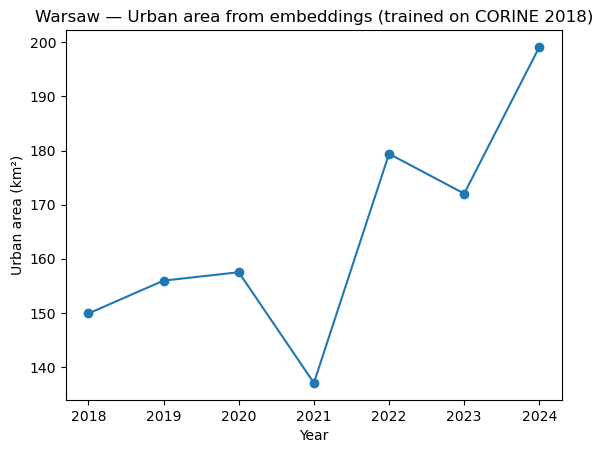

In [ ]:
plt.figure()
plt.plot(df_warsaw["year"], df_warsaw["urban_km2"], marker="o")
plt.xlabel("Year")
plt.ylabel("Urban area (km²)")
plt.title("Warsaw — Urban area from embeddings (trained on CORINE 2018)")
plt.show()


In [ ]:
m = geemap.Map()
aoi = city_aoi("warsaw")
m.centerObject(aoi, 9)

emb2021 = annual_embeddings(2021, aoi)
m.addLayer(emb2021, {"min": -0.5, "max": 0.5, "bands": ["A01", "A16", "A09"]}, "Embeddings 2021 (pseudo-RGB)")

emb2022 = annual_embeddings(2022, aoi)
m.addLayer(emb2022, {"min": -0.5, "max": 0.5, "bands": ["A01", "A16", "A09"]}, "Embeddings 2022 (pseudo-RGB)")

clc = ee.Image("COPERNICUS/CORINE/V20/100m/2018").select("landcover").clip(aoi)
m.addLayer(clc, {}, "CORINE 2018 landcover")

m


Map(center=[52.229725646962365, 21.012201161188926], controls=(WidgetControl(options=['position', 'transparent…

Map(center=[52.229725646962365, 21.012201161188926], controls=(WidgetControl(options=['position', 'transparent…

In [14]:
aoi = city_aoi("warsaw")

m = geemap.Map()
m.centerObject(aoi, 9)

# AOI outline (red)
aoi_outline = ee.Image().paint(aoi, 1, 3)
m.addLayer(aoi_outline, {"palette": ["red"]}, "AOI outline")

m


Map(center=[52.229725646962365, 21.012201161188926], controls=(WidgetControl(options=['position', 'transparent…